In [129]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [130]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_NBEATS_model_03.pth.tar"   # file name to save the model under

EPOCHS = 100
INLEN = 5        # input size
BLOCKS = 16         
LWIDTH = 32
BATCH = 4          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

SPLIT = pd.to_datetime('2022-08')         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

In [131]:
def import_csv_dateindex(csv_file):
    df = pd.read_csv(f'../data/{csv_file}')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').asfreq('B')
    return df

In [132]:
rubber = import_csv_dateindex('../data/rubber.csv')

In [133]:
rubber.head()

,cup_lump,rubber_sheet,ribbed_smoked_sheet,latex,fob,tocom,sicom,jpy,sgd,usd,crude_oil
date,,,,,,,,,,,
2017-09-19,NaN,52.56,55.04,51.50,60.10,208.80,174.30,3.37,24.56,0.03,51.77
2017-09-20,NaN,51.51,53.28,50.50,59.70,210.00,178.20,3.39,24.54,0.03,51.79
2017-09-21,NaN,51.51,53.14,50.00,59.70,207.80,175.30,3.40,24.53,0.03,51.63
2017-09-22,NaN,51.78,53.30,50.00,58.70,207.00,176.50,3.39,24.58,0.03,51.67
2017-09-25,NaN,50.58,53.22,50.00,58.70,207.00,178.00,3.38,24.50,0.03,51.41


In [134]:
rubber.drop(['cup_lump', 'usd'], axis=1, inplace=True)

In [135]:
# create time series object for target variable
ts_P = TimeSeries.from_series(rubber["ribbed_smoked_sheet"], freq='B') 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['ribbed_smoked_sheet'], dtype='object', name='component')
duration: 1868 days 00:00:00
frequency: <BusinessDay>
frequency: B
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [136]:
# create time series object for the feature columns
df_covF = rubber.loc[:, rubber.columns != "ribbed_smoked_sheet"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['rubber_sheet', 'latex', 'fob', 'tocom', 'sicom', 'jpy', 'sgd',
       'crude_oil'],
      dtype='object', name='component')
duration: 1868 days 00:00:00
frequency: <BusinessDay>
frequency: B
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [137]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2017-09-19 00:00:00
training end: 2022-08-01 00:00:00
training duration: 1777 days 00:00:00
test start: 2022-08-02 00:00:00
test end: 2022-10-31 00:00:00
test duration: 90 days 00:00:00
first and last row of scaled price time series:


component,ribbed_smoked_sheet
date,
2017-09-19,0.41
2022-10-31,0.29


In [138]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil
date,,,,,,,,
2017-09-19,0.41,0.45,0.40,0.38,0.29,0.21,0.57,0.21
2022-10-31,0.27,0.35,0.36,0.41,0.14,1.03,1.08,0.63


In [139]:
# feature engineering - create time covariates: hour, weekday, month, year, country-specific holidays
covT = datetime_attribute_timeseries( ts_P.time_index, attribute="day", add_length=22)   # 48 hours beyond end of test set to prepare for out-of-sample forecasting
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="day_of_week")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="quarter")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="year")  )

covT = covT.astype(np.float32)


# train/test split
covT_train, covT_test = covT.split_after(ts_train.end_time())


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,day,day_of_week,month,quarter,year
time,,,,,
2017-09-19,19,1,9,3,2017
2022-11-30,30,2,11,4,2022


In [140]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_ttrain = covF_ttrain.concatenate( covT_ttrain.slice_intersect(covF_ttrain), axis=1 )   # scaled F+T training set
cov_ttest = covF_ttest.concatenate( covT_ttest.slice_intersect(covF_ttest), axis=1 )       # scaled F+T test set
cov_t = cov_t.astype(np.float32)

# train/test split
covT_train, covT_test = covT.split_after(ts_train.end_time())


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,day,day_of_week,month,quarter,year
date,,,,,,,,,,,,,
2017-09-19,52.56,51.50,60.10,208.80,174.30,3.37,24.56,51.77,19.00,1.00,9.00,3.00,2017.00
2022-10-31,47.03,47.00,58.15,215.70,149.90,3.91,26.87,86.53,31.00,0.00,10.00,4.00,2022.00


In [141]:

model = NBEATSModel(    
    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_EnergyES",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True
                    )

In [142]:
# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = NBEATSModel.load_model(mpath)                            # load previously model from disk 
else:
    model.fit(  series=ts_ttrain, 
                past_covariates=cov_t, 
                val_series=ts_ttest, 
                val_past_covariates=cov_t, 
                verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

have saved the model after training: D:\tda\dsi\capstone\code\_NBEATS_model_03.pth.tar


In [143]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest),  
                            past_covariates=cov_t,
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)
                            
                            
                            
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_test, ts_q50) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
    
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

Predicting: 317it [00:00, ?it/s]

RMSE: 2.37
MAPE: 4.22


,Actual,Q50,Q10,Q20,Q30,Q40,Q60,Q70,Q80,Q90
date,,,,,,,,,,
2022-08-02,56.29,55.62,55.10,55.33,55.40,55.47,55.78,56.21,56.64,57.07
2022-08-03,55.95,54.81,54.17,54.38,54.62,54.72,54.90,55.05,55.39,56.24
2022-10-28,49.76,46.57,45.85,46.14,46.30,46.42,46.64,46.86,47.06,47.51
2022-10-31,49.47,46.40,45.61,45.86,46.21,46.28,46.55,46.74,46.99,47.44


In [144]:
for col in dfY.columns:
    print(f"mape {col} {mape(TimeSeries.from_series(dfY['Actual'], freq='W'), TimeSeries.from_series(dfY[col], freq='W'))}")

mape Actual 0.0
mape Q50 4.224797856638026
mape Q10 5.500595054436612
mape Q20 4.927431404379247
mape Q30 4.603867588569085
mape Q40 4.404139118118473
mape Q60 4.0004926864590935
mape Q70 3.6603675264283946
mape Q80 3.189436540826713
mape Q90 2.750382475458661


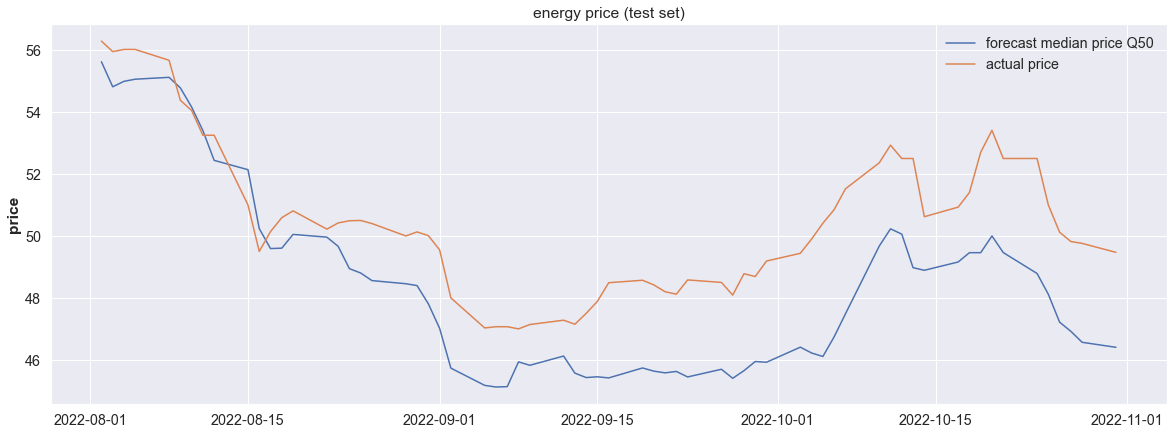

In [145]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "date", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "date", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
p.set_title("energy price (test set)");

In [146]:
# choose forecast horizon: k hours beyond end of test set
k = 20   

n_FC = k + len(ts_ttest)   # length of test set + k hours
print("forecast beyond end of training set:", n_FC, 
      "hours beyond", ts_ttrain.end_time())

# last 24 hours of feature covariates available => copy them to future 24 hours:
covF_t_fut = covF_t.concatenate(    other=covF_t.tail(size=22), 
                                    ignore_time_axis=True)
# combine feature and time covariates:
cov_t_fut = covF_t_fut.concatenate(covT_t.slice_intersect(covF_t_fut), axis=1) 
cov_t_fut = cov_t_fut.astype(np.float32)
cov_t_fut.pd_dataframe().iloc[[0,-1]]

forecast beyond end of training set: 85 hours beyond 2022-08-01 00:00:00


component,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,day,day_of_week,month,quarter,year
date,,,,,,,,,,,,,
2017-09-19,0.41,0.45,0.40,0.38,0.29,0.21,0.57,0.21,0.60,0.25,0.73,0.67,0.00
2022-11-30,0.27,0.35,0.36,0.41,0.14,1.03,1.08,0.63,0.97,0.50,0.91,1.00,1.00


In [147]:
# forecast from end of training set until k hours beyond end of test set
ts_tpred = model.predict(   n=n_FC, 
                            past_covariates=cov_t_fut, 
                            num_samples=N_SAMPLES, 
                            verbose=True, 
                            n_jobs=N_JOBS)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())

Predicting: 317it [00:00, ?it/s]

start: 2022-08-02 00:00:00 ; end: 2022-11-28 00:00:00


In [148]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
#dfY["Actual"] = TimeSeries.pd_series(ts_test)
 
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left, then insert Actual column
col = dfY.pop("Q50")
dfY.insert(0, col.name, col)
dfY.insert(0, "Actual", TimeSeries.pd_series(ts_test))

# show first and last 13 timestamps of forecast
dfY.iloc[np.r_[0:1, -13:0]]  

RMSE: 2.36
MAPE: 4.20


,Actual,Q50,Q10,Q20,Q30,Q40,Q60,Q70,Q80,Q90
date,,,,,,,,,,
2022-08-02,56.29,55.66,54.94,55.31,55.39,55.44,55.79,56.16,56.60,56.99
2022-11-10,NaN,50.12,49.37,49.70,49.85,49.93,50.27,50.72,50.93,51.25
2022-11-11,NaN,50.17,49.22,49.58,49.84,50.06,50.32,50.53,50.92,51.29
2022-11-14,NaN,49.45,48.57,48.91,49.11,49.22,49.57,49.92,50.29,50.59
2022-11-15,NaN,49.09,48.28,48.49,48.81,48.95,49.19,49.41,49.99,50.31
2022-11-16,NaN,48.73,48.12,48.35,48.48,48.56,48.84,48.95,49.46,49.93
2022-11-17,NaN,49.15,48.30,48.77,48.92,49.06,49.27,49.47,50.00,50.32
2022-11-18,NaN,49.55,48.80,49.15,49.35,49.45,49.73,50.00,50.28,50.63
2022-11-21,NaN,50.14,49.27,49.71,49.94,50.04,50.29,50.44,50.82,51.14


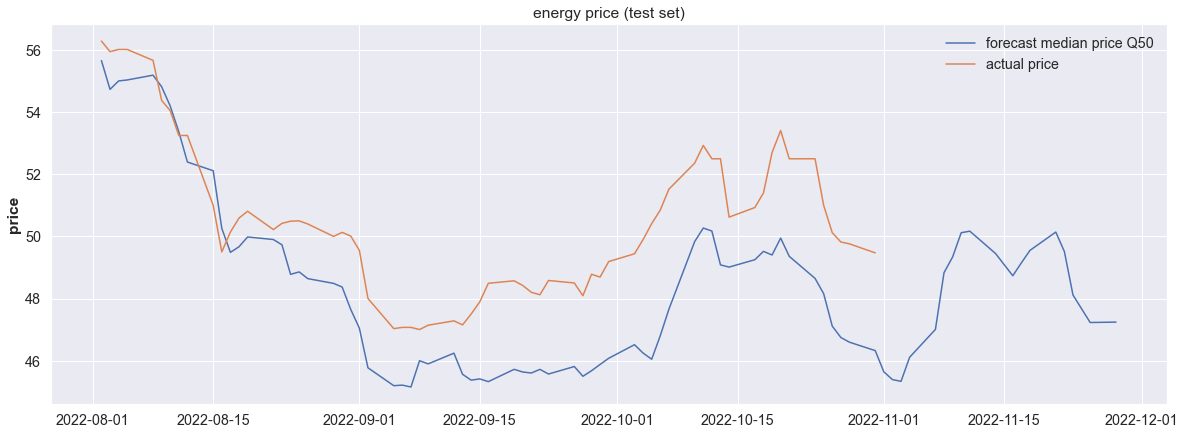

In [149]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "date", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "date", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
p.set_title("energy price (test set)");